<h1 style="text-align: center;">Diagnosis of Tomato Disease</h1>

# 1- Importing libraries

In [1]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')

modules loaded


# Create needed functions

Function to create dataframe

In [2]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    
    # valid and test dataframe
    files, classes = define_paths(tr_dir)
    dummy_df = define_df(files, classes)
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123, stratify= strat)
    return train_df, valid_df, test_df

Function to generate images from dataframe

In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

Function to show images

In [4]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

Callback Class

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, initial_epoch, epochs):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

Function to plot history of training

In [6]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

Function to create Confusion Matrix

In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# Model Structure

Show images sample

Found 25851 validated image filenames belonging to 11 classes.
Found 15510 validated image filenames belonging to 11 classes.
Found 10341 validated image filenames belonging to 11 classes.


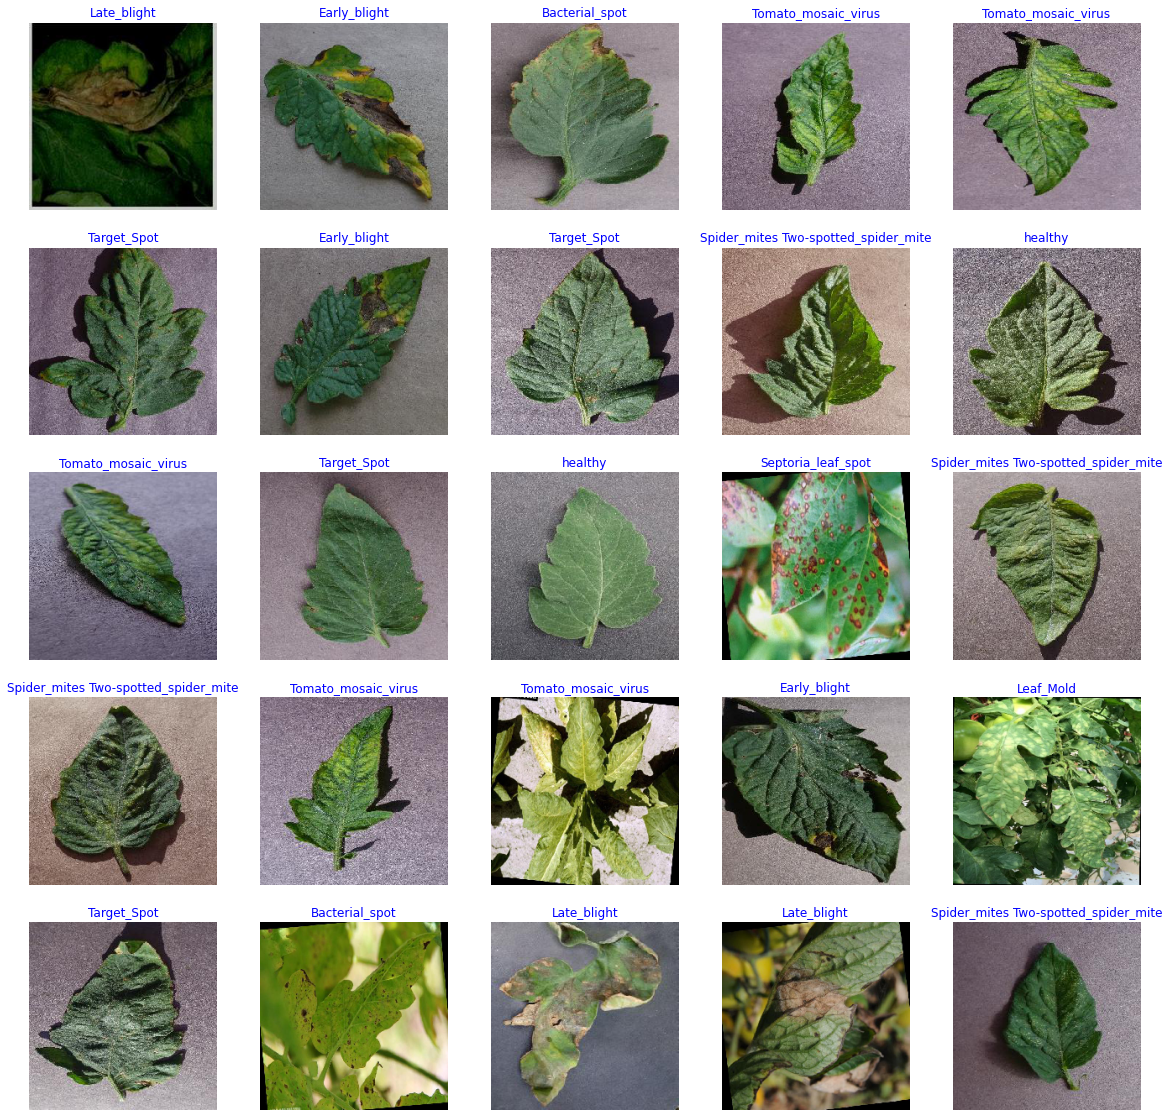

In [9]:
# Get Dataframes
train_dir = '../input/tomato-disease-multiple-sources/train'
valid_dir = '../input/tomato-disease-multiple-sources/valid'
train_df, valid_df, test_df = create_df(train_dir, valid_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

Create Pre-trained model

Text(0.5, 1.0, 'Data Distribution (Pie Chart)')

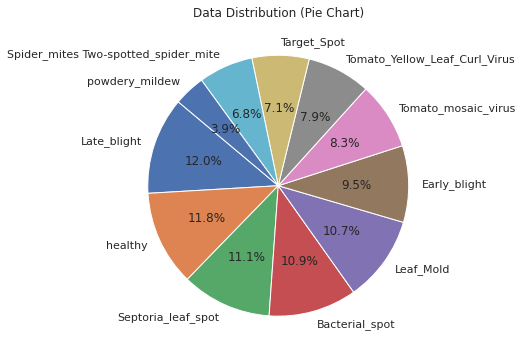

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# إعدادات عامة
plt.style.use('seaborn-darkgrid')
sns.set(font_scale=1.0)  # تقليل حجم الخط قليلاً

# توزيع الفئات
label_counts = train_df['labels'].value_counts()

# رسم المخططات
plt.figure(figsize=(22, 6))  # تكبير الشكل أكثر

# 1. Pie Chart
plt.subplot(1, 3, 1)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Data Distribution (Pie Chart)', fontsize=12)

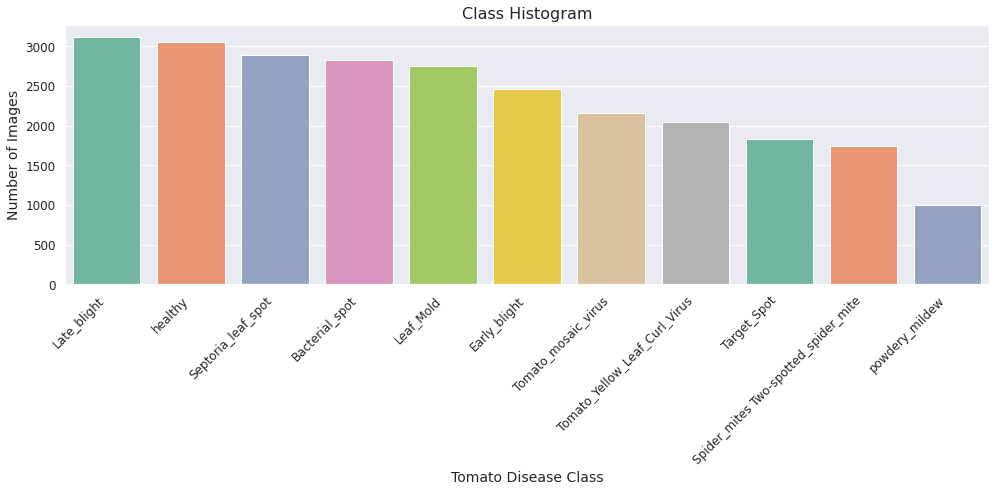

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# بيانات التوزيع
label_counts = train_df['labels'].value_counts()

# تكبير الرسم البياني الهستوجرام
plt.figure(figsize=(14, 7))  # ← تكبير العرض والارتفاع

sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.title('Class Histogram', fontsize=16)
plt.xlabel('Tomato Disease Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


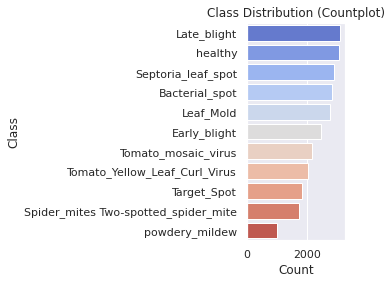

In [12]:
# 3. Countplot
plt.subplot(1, 3, 3)
sns.countplot(y='labels', data=train_df, palette='coolwarm', order=label_counts.index)
plt.title('Class Distribution (Countplot)', fontsize=12)
plt.xlabel('Count')
plt.ylabel('Class')

plt.tight_layout(pad=3.0)  # زيادة المسافة بين الرسوم

plt.show()

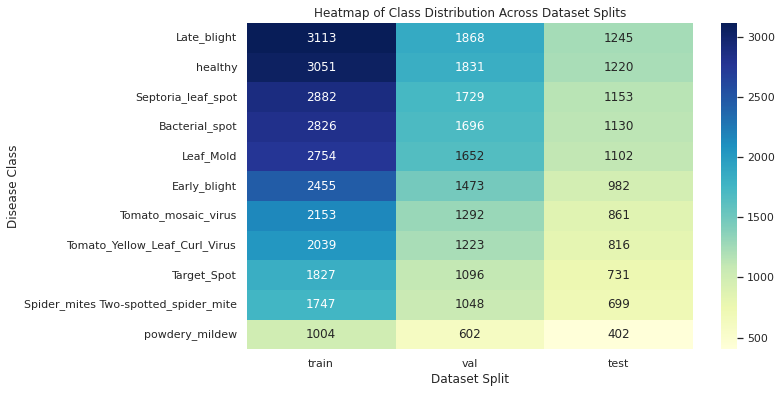

In [13]:
# دمج البيانات لتوزيعها على Train / Val / Test لكل فئة
data_distribution = pd.DataFrame({
    'train': train_df['labels'].value_counts(),
    'val': valid_df['labels'].value_counts(),
    'test': test_df['labels'].value_counts()
}).fillna(0).astype(int)

# رسم خريطة الحرارة
plt.figure(figsize=(10, 6))
sns.heatmap(data_distribution, annot=True, fmt="d", cmap='YlGnBu')
plt.title('Heatmap of Class Distribution Across Dataset Splits')
plt.xlabel('Dataset Split')
plt.ylabel('Disease Class')
plt.show()

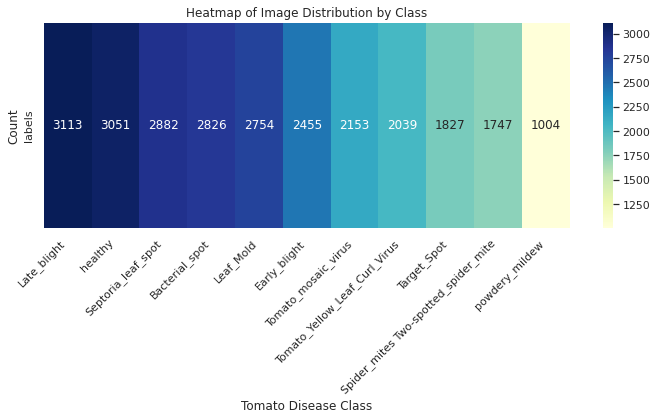

In [14]:
# إنشاء جدول التكرار بناءً على الفئات (labels)
heatmap_data = train_df['labels'].value_counts().to_frame().T

# رسم الهيتماب
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Image Distribution by Class')
plt.xlabel('Tomato Disease Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
# Create Model Structure
img_size = (224, 224)  # Set image size manually
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Count number of classes
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

# Build final model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, 
          kernel_regularizer=regularizers.l2(0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), 
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Print summary
model.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                2827      
Total params: 11,185,978
Trainable params: 11,095,603
Non-trainable params: 90,375
_________________________________________________________________


Get custom callbacks parameters

In [16]:
batch_size = 40
epochs = 5
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
freeze = False
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs)]

Train model

In [17]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /5      4.365   84.063   1.55918  97.163   0.00100  0.00100  accuracy     0.00    405.73 
 2 /5      0.918   95.652   0.41900  99.014   0.00100  0.00100  val_loss    73.13    379.78 
 3 /5      0.404   97.447   0.26626  99.329   0.00100  0.00100  val_loss    36.45    379.86 
 4 /5      0.300   98.348   0.21715  99.478   0.00100  0.00100  val_loss    18.44    379.85 
 5 /5      0.253   98.662   0.20032  99.446   0.00100  0.00100  val_loss     7.75    379.10 
training elapsed time was 0.0 hours, 32.0 minutes, 5.03 seconds)


Plot training history

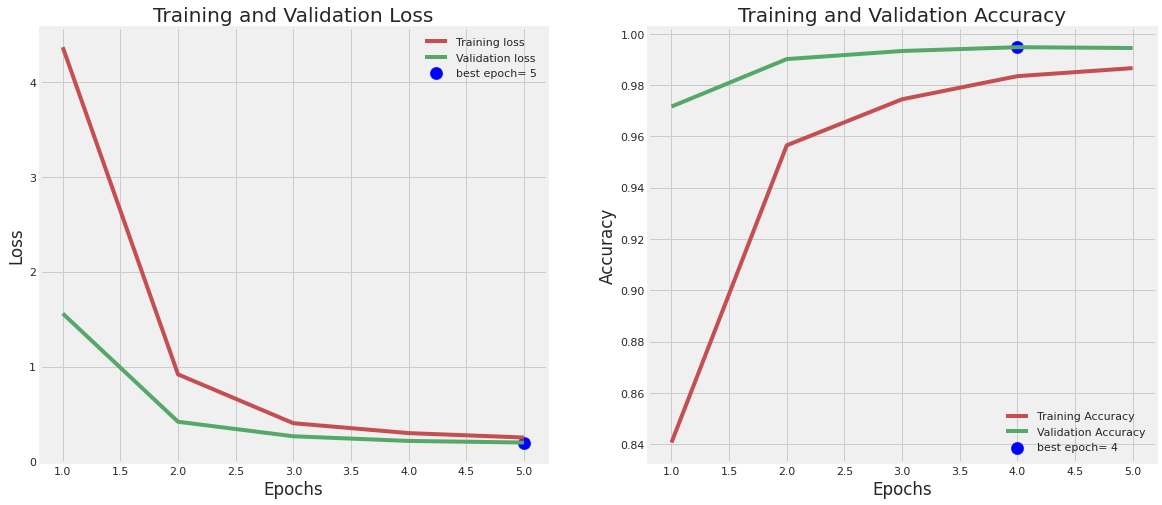

In [18]:
plot_training(history)

Evaluate model

In [19]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

383/383 [==============================] - 37s 96ms/step - loss: 0.1969 - accuracy: 0.9952
Train Loss:  0.20009498298168182
Train Accuracy:  0.9947780966758728
--------------------
Validation Loss:  0.20017924904823303
Validation Accuracy:  0.9945822358131409
--------------------
Test Loss:  0.19692590832710266
Test Accuracy:  0.9951648712158203


Make prediction

In [20]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[10  9  0 ...  8  3  2]


Confusion Matrix and Classification Report

Confusion Matrix, Without Normalization
[[1115    2    0    0   10    0    0    0    0    0    3]
 [   0  980    0    0    2    0    0    0    0    0    0]
 [   1    1 1240    0    0    0    0    0    1    0    2]
 [   1    0    0 1101    0    0    0    0    0    0    0]
 [   0    2    0    0 1150    0    0    0    0    0    1]
 [   0    0    0    0    0  678   21    0    0    0    0]
 [   0    0    0    0    0    0  731    0    0    0    0]
 [   0    0    0    0    0    0    0  816    0    0    0]
 [   0    0    0    1    1    0    0    0  859    0    0]
 [   0    0    0    0    0    0    0    0    0 1220    0]
 [   0    1    0    0    0    0    0    0    0    0  401]]
                               precision    recall  f1-score   support

               Bacterial_spot       1.00      0.99      0.99      1130
                 Early_blight       0.99      1.00      1.00       982
                  Late_blight       1.00      1.00      1.00      1245
                    Leaf_Mold       

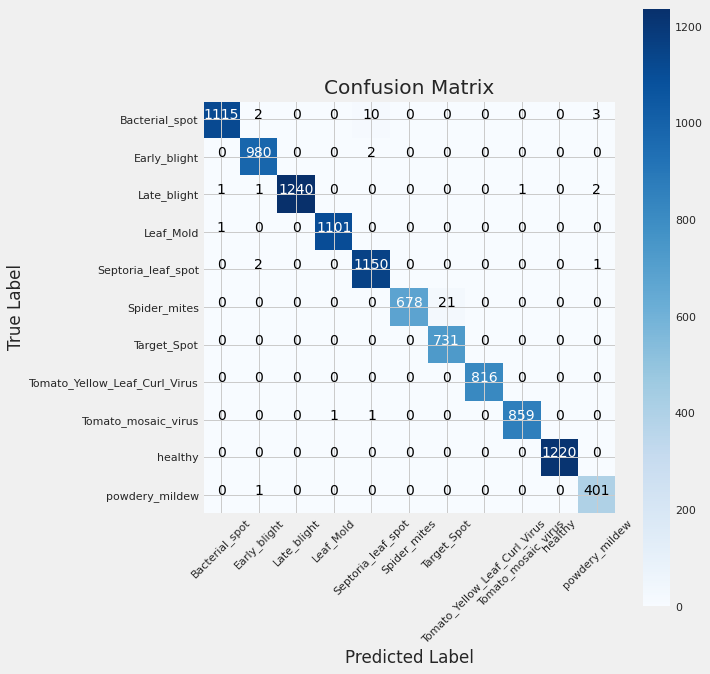

In [21]:
target_names = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

Save model

In [22]:
model_name = 'EffecientNetB3'
subject = 'Tomato-Disease-Detection'
acc = test_score[1] * 100
save_path = ''

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


model was saved as EffecientNetB3-Tomato-Disease-Detection-99.52.h5


Save class indices in CSV

In [23]:
class_dict = train_gen.class_indices
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
subject = ''
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as -class_dict.csv


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
import numpy as np

def plot_training_metrics(history, y_true, y_pred_proba):
    # 1. Training & Validation Loss
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. PR Curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-6)

    # 3. F1 Score vs Confidence Threshold
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, f1_scores[:-1])
    plt.title("F1 Score vs Confidence")
    plt.xlabel("Confidence Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # 4. Precision vs Confidence
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, precision[:-1])
    plt.title("Precision vs Confidence")
    plt.xlabel("Confidence Threshold")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()

    # 5. Recall vs Confidence
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, recall[:-1])
    plt.title("Recall vs Confidence")
    plt.xlabel("Confidence Threshold")
    plt.ylabel("Recall")
    plt.grid(True)
    plt.show()

    # 6. Precision-Recall Curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()

In [25]:
import pandas as pd
import seaborn as sns

def plot_label_statistics(df_labels):
    plt.figure(figsize=(12, 10))

    # Top-left: Class distribution
    plt.subplot(2, 2, 1)
    sns.countplot(x='class', data=df_labels)
    plt.title("Label Distribution by Class")
    plt.xticks(rotation=45)

    # Top-right: Label size (area)
    plt.subplot(2, 2, 2)
    sizes = df_labels['width'] * df_labels['height']
    sns.histplot(sizes, bins=30, kde=True)
    plt.title("Size Distribution (Area)")

    # Bottom-left: X-Y coordinates
    plt.subplot(2, 2, 3)
    plt.scatter(df_labels['x_center'], df_labels['y_center'], alpha=0.5)
    plt.title("Horizontal vs Vertical Coordinates")
    plt.xlabel("x_center")
    plt.ylabel("y_center")

    # Bottom-right: Width vs Height
    plt.subplot(2, 2, 4)
    plt.scatter(df_labels['width'], df_labels['height'], alpha=0.5)
    plt.title("Width vs Height")
    plt.xlabel("width")
    plt.ylabel("height")

    plt.tight_layout()
    plt.show()

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
import numpy as np

# Assuming you have predictions and true labels from validation set
# y_true: ground truth labels
# y_probs: predicted class probabilities (e.g., from model.predict())

def plot_confidence_curves(y_true, y_probs):
    y_pred = np.argmax(y_probs, axis=1)
    confidence_scores = np.max(y_probs, axis=1)

    precisions = []
    recalls = []
    f1s = []
    thresholds = np.linspace(0, 1, 100)

    for t in thresholds:
        preds = (confidence_scores >= t).astype(int)
        p = precision_score(y_true, preds, average='macro', zero_division=0)
        r = recall_score(y_true, preds, average='macro', zero_division=0)
        f = f1_score(y_true, preds, average='macro', zero_division=0)

        precisions.append(p)
        recalls.append(r)
        f1s.append(f)

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(thresholds, f1s, label='F1 Score')
    plt.title("F1 vs Confidence")
    plt.xlabel("Confidence Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)

    plt.subplot(2, 2, 2)
    precision, recall, _ = precision_recall_curve(y_true, confidence_scores)
    plt.plot(recall, precision, label='PR Curve')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(thresholds, precisions, label='Precision', color='green')
    plt.title("Precision vs Confidence")
    plt.xlabel("Confidence Threshold")
    plt.ylabel("Precision")
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(thresholds, recalls, label='Recall', color='red')
    plt.title("Recall vs Confidence")
    plt.xlabel("Confidence Threshold")
    plt.ylabel("Recall")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [27]:
def plot_loss_curves(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [28]:
import pandas as pd

# Assuming y_train contains integer labels and image shapes (e.g., from ImageDataGenerator)

def plot_label_distribution(y_train, image_shapes=None):
    label_counts = pd.Series(y_train).value_counts().sort_index()

    plt.figure(figsize=(12, 10))

    # Top-left: Label Distribution
    plt.subplot(2, 2, 1)
    label_counts.plot(kind='bar')
    plt.title("Label Distribution")
    plt.xlabel("Class")
    plt.ylabel("Frequency")

    # Top-right: Size Distribution (only if image_shapes provided)
    if image_shapes:
        areas = [w*h for (w, h) in image_shapes]
        plt.subplot(2, 2, 2)
        plt.hist(areas, bins=20, color='orange')
        plt.title("Size Distribution (Image Areas)")
        plt.xlabel("Area")
        plt.ylabel("Count")

        # Bottom-left: X, Y coordinates of centers
        xs = [w/2 for (w, h) in image_shapes]
        ys = [h/2 for (w, h) in image_shapes]
        plt.subplot(2, 2, 3)
        plt.scatter(xs, ys, alpha=0.5)
        plt.title("Horizontal vs Vertical Centers")
        plt.xlabel("X Center")
        plt.ylabel("Y Center")

        # Bottom-right: Width vs Height
        widths = [w for (w, h) in image_shapes]
        heights = [h for (w, h) in image_shapes]
        plt.subplot(2, 2, 4)
        plt.scatter(widths, heights, alpha=0.5)
        plt.title("Height vs Width")
        plt.xlabel("Width")
        plt.ylabel("Height")

    plt.tight_layout()
    plt.show()

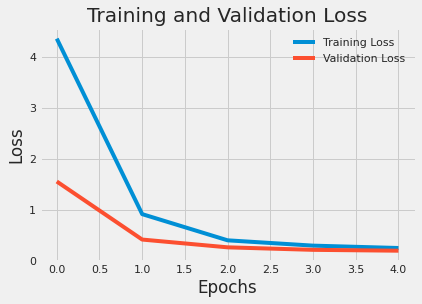

NameError: name 'y_true' is not defined

In [29]:
# Example usage after training
# history = model.fit(...) returns history
plot_loss_curves(history)

# If using model.predict on validation set
# y_true = true class labels
# y_probs = model.predict(X_val)
plot_confidence_curves(y_true, y_probs)

# Label plots
# y_train = list of class labels
# image_shapes = [(width, height), ...] for each image
plot_label_distribution(y_train, image_shapes=image_shapes)

In [36]:
plot_training_metrics(history, y_true, y_probs)

NameError: name 'y_true' is not defined

In [32]:
# Assuming `df_labels` is your DataFrame containing label information
plot_label_statistics(df_labels)

NameError: name 'df_labels' is not defined

In [33]:
# For this function, provide `y_true` as true labels and `y_probs` as model predictions
plot_confidence_curves(y_true, y_probs)

NameError: name 'y_true' is not defined

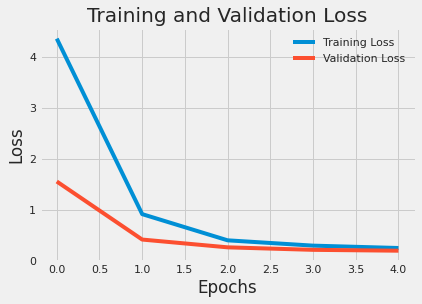

In [34]:
# Call plot_loss_curves for the model's `history`
plot_loss_curves(history)

In [35]:
# Here `y_train` is the list of class labels and `image_shapes` the size of images
plot_label_distribution(y_train, image_shapes=image_shapes)

NameError: name 'y_train' is not defined

In [1]:
# After model training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[...]
)

# Get true labels and predicted probabilities from validation set
# Assuming binary classification (e.g., healthy vs diseased)
import numpy as np

# Get true labels
y_true = val_generator.classes

# Get predicted probabilities
y_pred_proba = model.predict(val_generator, verbose=1)

# If multi-class, convert to probabilities of the positive class (or use argmax)
if y_pred_proba.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
    y_pred_proba = y_pred_proba[:, 1]  # or pick the target class index

# Call the function
plot_training_metrics(history, y_true, y_pred_proba)


NameError: name 'model' is not defined